In [11]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
batch_size = 32
learning_rate = 1e-3
input_size = 28
sequence_len = 28
num_layers = 2
hidden_size = 128
num_epochs = 8
num_classes = 10
load_model = True

In [14]:
train_data = datasets.MNIST(root = 'Datasets\\', train = True, transform = transforms.ToTensor(), download = False)
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_data = datasets.MNIST(root = 'Datasets\\', train = False, transform = transforms.ToTensor(), download = False)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = False)

In [15]:
class Bi_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers):
        super(Bi_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True, bidirectional = True)
        self.fc = nn.Linear(hidden_size*2, num_classes)

    def forward(self, x):
        ho = torch.randn(self.num_layers*2, x.shape[0], self.hidden_size).to(device)
        co = torch.randn(self.num_layers*2, x.shape[0], self.hidden_size).to(device)

        out, (hn, cn) = self.lstm(x, (ho, co))
        out = self.fc(out[:, -1, :])
        return out

In [16]:
def save_checkpoint(state, filepath = 'my_model.pth'):
    print('=> Saving checkpoint')
    torch.save(state, filepath)

In [36]:
def load_checkpoint(checkpoint):
    print('Loading checkpoint')
    model.load_state_dict(checkpoint['state_dict'])
    model.to(device)
    optimizer.load_state_dict(checkpoint['optimizer'])

In [18]:
model = Bi_LSTM(input_size = input_size, hidden_size = hidden_size, num_classes = num_classes, num_layers = num_layers).to(device)

In [19]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(params = model.parameters(), lr = learning_rate)

In [20]:
loss_cummulative = []
for epoch in range(num_epochs):

    if epoch != 0 and epoch % 2 == 0:
        checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
        print(f'Epoch {epoch}:', loss_cummulative[-1])
        save_checkpoint(checkpoint)

    for (data, label) in train_loader:
        data = data.to(device).squeeze()
        label = label.to(device)

        Y_pred = model(data)
        loss = loss_func(Y_pred, label)
        loss_cummulative.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

Epoch 2: 0.11308343708515167
=> Saving checkpoint
Epoch 4: 0.11992066353559494
=> Saving checkpoint
Epoch 6: 0.009353105910122395
=> Saving checkpoint


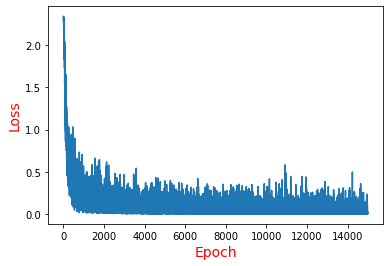

In [29]:
plt.plot(loss_cummulative)
plt.xlabel('Epoch', fontsize = 14, c = 'r')
plt.ylabel('Loss', fontsize = 14, c = 'r')
plt.show()

In [22]:
def check_acc(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for data, labels in loader:
            data = data.to(device).squeeze(1)
            labels = labels.to(device)

            Y_pred = model(data)
            _, max_idx = Y_pred.max(dim = 1)

            num_correct += (max_idx == labels).sum()
            num_samples += Y_pred.shape[0]
        
        print(f"Got {num_correct}/{num_samples} with accuracy {num_correct/num_samples*100:.2f}")

In [23]:
check_acc(test_loader, model)

Got 9871/10000 with accuracy 98.71


In [37]:
if load_model:
    load_checkpoint(torch.load('my_model.pth'))

Loading checkpoint


In [39]:
loss_cummulative = []
model.train()
for epoch in range(num_epochs):

    if epoch != 0 and epoch % 2 == 0:
        checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
        print(f'Epoch {epoch}:', loss_cummulative[-1])
        save_checkpoint(checkpoint)

    for (data, label) in train_loader:
        data = data.to(device).squeeze()
        label = label.to(device)

        Y_pred = model(data)
        loss = loss_func(Y_pred, label)
        loss_cummulative.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

Epoch 2: 0.0019194057676941156
=> Saving checkpoint
Epoch 4: 0.001912266481667757
=> Saving checkpoint
Epoch 6: 0.006124410312622786
=> Saving checkpoint


In [53]:
new_optimizer = optim.RMSprop(params = model.parameters(), lr = 1e-4)
check_point = {"epoch": 5, 'optim_state': new_optimizer.state_dict()}

In [54]:
optimizer.load_state_dict(check_point['optim_state'])
no_epochss = check_point['epoch']

In [55]:
loss_cummulative = []
model.train()
for epoch in range(no_epochss):

    if epoch != 0 and epoch % 2 == 0:
        checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
        print(f'Epoch {epoch}:', loss_cummulative[-1])
        save_checkpoint(checkpoint)

    for (data, label) in train_loader:
        data = data.to(device).squeeze()
        label = label.to(device)

        Y_pred = model(data)
        loss = loss_func(Y_pred, label)
        loss_cummulative.append(loss.item())
        
        new_optimizer.zero_grad()
        loss.backward()

        new_optimizer.step()

Epoch 2: 4.2503328586462885e-05
=> Saving checkpoint
Epoch 4: 0.0001963758550118655
=> Saving checkpoint


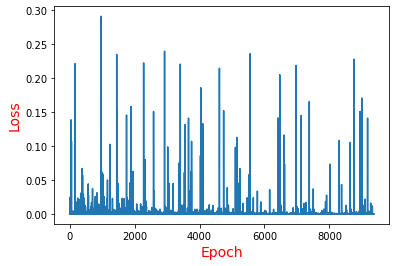

In [56]:
plt.plot(loss_cummulative)
plt.xlabel('Epoch', fontsize = 14, c = 'r')
plt.ylabel('Loss', fontsize = 14, c = 'r')
plt.show()